Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


k-means inertia (k=5): 3856.682293123528


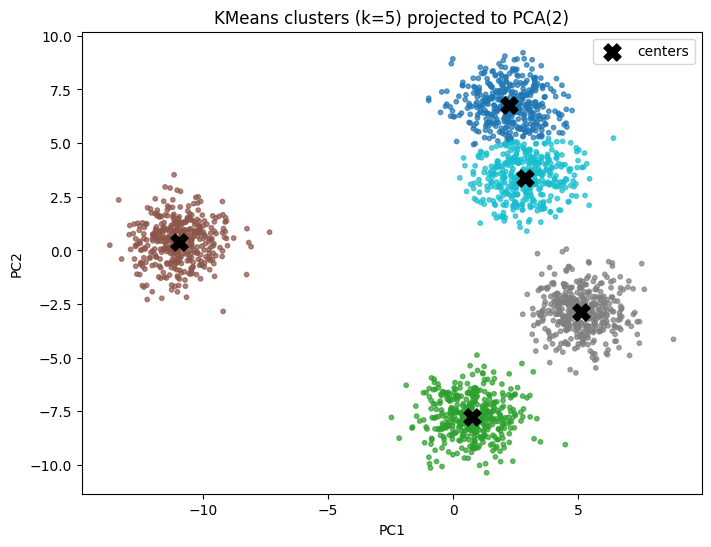

Confusion matrix (rows=true, cols=pred after best matching):
 [[399   0   0   1   0]
 [  0 384   0   0  16]
 [  0   0 400   0   0]
 [  0   0   0 400   0]
 [  1  22   0   0 377]]


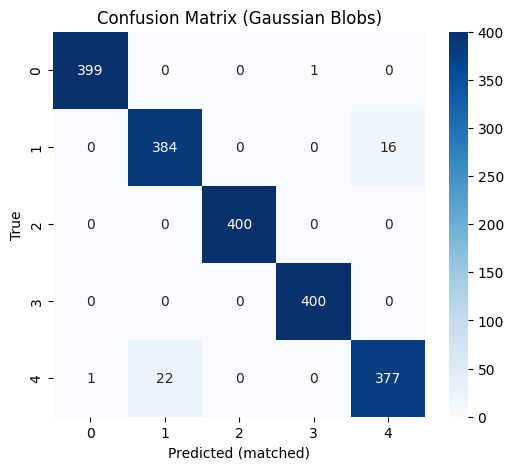

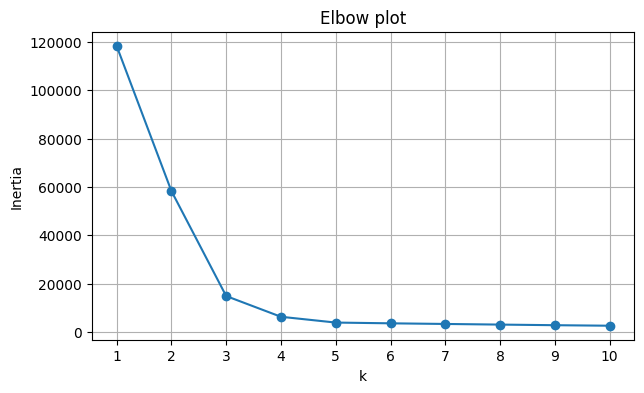

In [7]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns

from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=2000, centers=5, cluster_std=1.0, random_state=42)


k = 5
km = KMeans(n_clusters=k, random_state=42, n_init=10)
km.fit(X)
labels = km.labels_
inertia = km.inertia_
print("k-means inertia (k=5):", inertia)


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(km.cluster_centers_)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='black', s=150, marker='X', label='centers')
plt.legend()
plt.title("KMeans clusters (k=5) projected to PCA(2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.savefig("GaussianBlobs_KMeans_PCA.png", dpi=200)
plt.show()


cm = confusion_matrix(y_true, labels)

cost = cm.max() - cm
row_ind, col_ind = linear_sum_assignment(cost)
mapping = dict(zip(col_ind, row_ind))

labels_matched = np.array([mapping[l] for l in labels])


cm_matched = confusion_matrix(y_true, labels_matched)
print("Confusion matrix (rows=true, cols=pred after best matching):\n", cm_matched)


plt.figure(figsize=(6,5))
sns.heatmap(cm_matched, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted (matched)")
plt.ylabel("True")
plt.title("Confusion Matrix (Gaussian Blobs)")
plt.savefig("GaussianBlobs_ConfusionMatrix.png", dpi=200)
plt.show()

# Elbow analysis
inertias = []
ks = list(range(1,11))
for kk in ks:
    kmk = KMeans(n_clusters=kk, random_state=42, n_init=10)
    kmk.fit(X)
    inertias.append(kmk.inertia_)

plt.figure(figsize=(7,4))
plt.plot(ks, inertias, marker='o')
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow plot")
plt.grid(True)
plt.savefig("GaussianBlobs_Elbow.png", dpi=200)
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


Total images: 70000


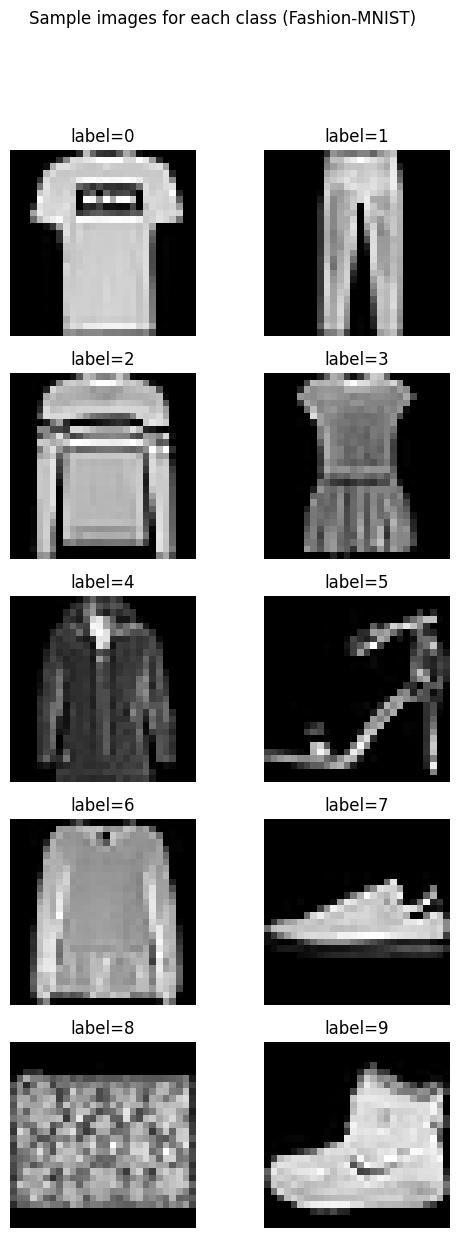

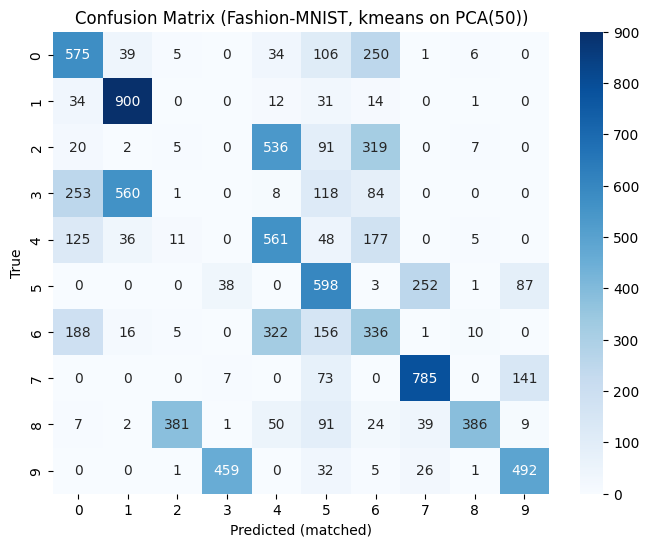

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import fashion_mnist
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import seaborn as sns


(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_all = np.vstack([X_train, X_test])
y_all = np.hstack([y_train, y_test])
n_total = X_all.shape[0]
print("Total images:", n_total)


fig, axes = plt.subplots(5,2, figsize=(6,14))
labels_to_show = list(range(10))[:10]  # 0..9
idxs = []
for label in labels_to_show:
    idx = np.where(y_all==label)[0][0]
    idxs.append(idx)
for ax, idx in zip(axes.flatten(), idxs):
    ax.imshow(X_all[idx], cmap='gray')
    ax.set_title(f"label={y_all[idx]}")
    ax.axis('off')
plt.suptitle("Sample images for each class (Fashion-MNIST)")
plt.savefig("FashionMNIST_samples_5x2.png", dpi=200)
plt.show()


X_flat = X_all.reshape((-1, 28*28)).astype(np.float32) / 255.0
sample_size = 10000
rng = np.random.default_rng(42)
sel = rng.choice(len(X_flat), size=sample_size, replace=False)
X_sample = X_flat[sel]
y_sample = y_all[sel]


pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X_sample)


k = 10
km = KMeans(n_clusters=k, random_state=42, n_init=10)
km.fit(X_reduced)
labels = km.labels_


cm = confusion_matrix(y_sample, labels)
cost = cm.max() - cm
row_ind, col_ind = linear_sum_assignment(cost)
mapping = dict(zip(col_ind, row_ind))
labels_matched = np.array([mapping[l] for l in labels])

cm_matched = confusion_matrix(y_sample, labels_matched)
plt.figure(figsize=(8,6))
sns.heatmap(cm_matched, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted (matched)")
plt.ylabel("True")
plt.title("Confusion Matrix (Fashion-MNIST, kmeans on PCA(50))")
plt.savefig("FashionMNIST_kmeans_confusion.png", dpi=200)
plt.show()


# 3. Dimensionality reduction for Fashion-MNIST

k=10: PCA corr=0.8910, RP corr=0.8155
k=20: PCA corr=0.9361, RP corr=0.8835
k=50: PCA corr=0.9786, RP corr=0.9539
k=100: PCA corr=0.9937, RP corr=0.9760
k=200: PCA corr=0.9982, RP corr=0.9850


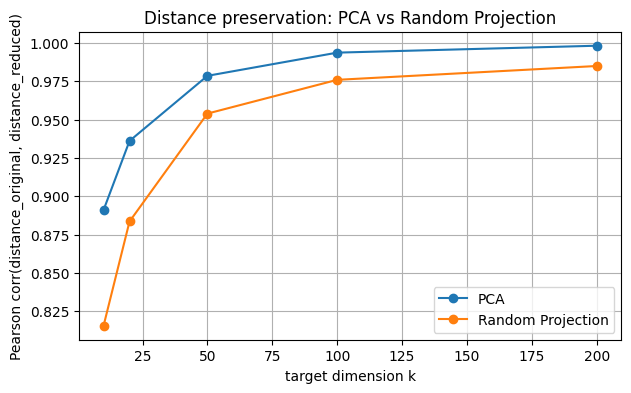

In [9]:

import numpy as np
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt


try:
    X_use = X_sample.copy()
except NameError:
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_all = np.vstack([X_train, X_test]).reshape(-1, 28*28).astype(np.float32)/255.0
    rng = np.random.default_rng(42)
    sel = rng.choice(len(X_all), size=5000, replace=False)
    X_use = X_all[sel]


scaler = StandardScaler()
X_std = scaler.fit_transform(X_use)

ks = [10,20,50,100,200]
corrs_pca = []
corrs_rp = []

N = X_std.shape[0]

orig_dist = pairwise_distances(X_std, metric='euclidean')

triu_idx = np.triu_indices_from(orig_dist, k=1)
orig_vec = orig_dist[triu_idx]

for k in ks:
    # PCA
    pca = PCA(n_components=k, random_state=42)
    Xp = pca.fit_transform(X_std)
    dp = pairwise_distances(Xp)
    dp_vec = dp[triu_idx]
    corr_p = np.corrcoef(orig_vec, dp_vec)[0,1]
    corrs_pca.append(corr_p)

    rp = GaussianRandomProjection(n_components=k, random_state=42)
    Xr = rp.fit_transform(X_std)
    dr = pairwise_distances(Xr)
    dr_vec = dr[triu_idx]
    corr_r = np.corrcoef(orig_vec, dr_vec)[0,1]
    corrs_rp.append(corr_r)
    print(f"k={k}: PCA corr={corr_p:.4f}, RP corr={corr_r:.4f}")

plt.figure(figsize=(7,4))
plt.plot(ks, corrs_pca, marker='o', label='PCA')
plt.plot(ks, corrs_rp, marker='o', label='Random Projection')
plt.xlabel('target dimension k')
plt.ylabel('Pearson corr(distance_original, distance_reduced)')
plt.title('Distance preservation: PCA vs Random Projection')
plt.legend()
plt.grid(True)
plt.savefig("PCA_RP_distance_corr.png", dpi=200)
plt.show()


# 4. Clustering Fashion-MNIST using spectral clustering

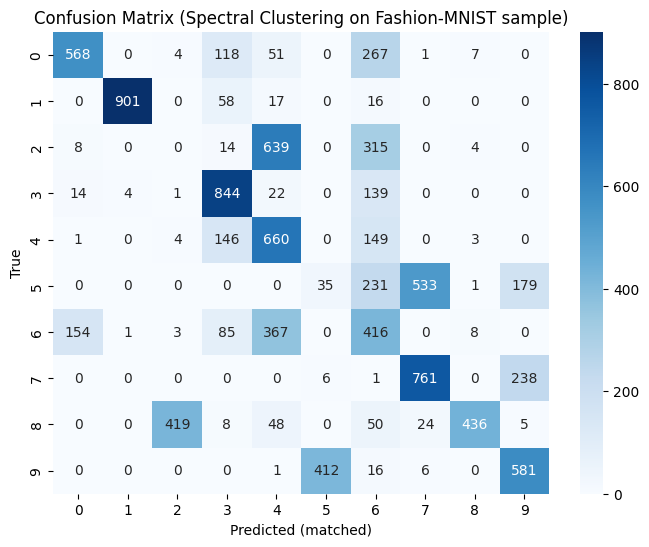

Adjusted Rand Index (spectral embedding + kmeans) vs true: 0.39972838309738123


In [10]:

from sklearn.cluster import SpectralClustering
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import adjusted_rand_score


try:
    X_for_sc = X_reduced.copy()
    y_for_sc = y_sample.copy()
except NameError:

    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_all = np.vstack([X_train, X_test]).reshape(-1, 28*28).astype(np.float32)/255.0
    rng = np.random.default_rng(42)
    sel = rng.choice(len(X_all), size=5000, replace=False)
    X_for_sc = X_all[sel]
    pca = PCA(n_components=50, random_state=42)
    X_for_sc = pca.fit_transform(X_for_sc)
    y_for_sc = y_all[sel]


k = 10
sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=10, random_state=42, assign_labels='kmeans')
labels_sc = sc.fit_predict(X_for_sc)


emb = SpectralEmbedding(n_components=10, affinity='nearest_neighbors', n_neighbors=10, random_state=42)
X_emb = emb.fit_transform(X_for_sc)
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_emb)
labels_sc2 = km.labels_


labels_used = labels_sc2


cm = confusion_matrix(y_for_sc, labels_used)
cost = cm.max() - cm
row_ind, col_ind = linear_sum_assignment(cost)
mapping = dict(zip(col_ind, row_ind))
labels_matched = np.array([mapping[l] for l in labels_used])
cm_matched = confusion_matrix(y_for_sc, labels_matched)

plt.figure(figsize=(8,6))
sns.heatmap(cm_matched, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted (matched)")
plt.ylabel("True")
plt.title("Confusion Matrix (Spectral Clustering on Fashion-MNIST sample)")
plt.savefig("FashionMNIST_Spectral_Confusion.png", dpi=200)
plt.show()


from sklearn.metrics import adjusted_rand_score
ari_kmeans = adjusted_rand_score(y_for_sc, labels_matched)
print("Adjusted Rand Index (spectral embedding + kmeans) vs true:", ari_kmeans)
